In [208]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import gc

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, Embedding, GlobalAveragePooling2D

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', -1)

In [211]:
data_original = pd.read_csv('data_rec.csv', sep = ';')
print(data_original.shape)
data_original.head()

(11652, 12)


,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime
0,MisterKap,2VQ2J0,81.0,SLO - PGM,9244388.0,3Musk,SameClan,"skeletons,giant-snowball,barbarian-barrel,bandit,hunter,battle-ram,elixir-collector,three-musketeers",1.0,0.0,1.0,2019-05-09 21:10:56.0000000
1,Arctic Peke,2RVPQRUV,77.0,SLO - Arctic Gaming,9244373.0,RoyalGiant,SameClan,"barbarian-barrel,mega-minion,earthquake,guards,electro-wizard,fireball,inferno-tower,royal-giant",1.0,1.0,0.0,2019-05-09 21:01:44.0000000
2,MisterKap,2VQ2J0,81.0,SLO - PGM,9244387.0,Golem,SameClan,"barbarian-barrel,mega-minion,tornado,lumberjack,baby-dragon,dark-prince,electro-dragon,golem",1.0,0.0,1.0,2019-05-09 20:56:19.0000000
3,Arctic Peke,2RVPQRUV,77.0,SLO - Arctic Gaming,9244372.0,Balloon,SameClan,"zap,ice-golem,barbarian-barrel,bats,miner,mega-minion,mini-pekka,balloon",1.0,1.0,0.0,2019-05-09 20:39:04.0000000
4,SAMU LA MOSKA™,29200QJQ,2.0,SLO - x6tence,9244339.0,MegaKnight,SameClan,"giant-snowball,goblin-gang,guards,miner,minions,wall-breakers,inferno-dragon,mega-knight",1.0,1.0,0.0,2019-05-09 20:37:02.0000000


### Data cleaning

In [212]:
data_original['date'] = pd.to_datetime(data_original['BattleTime']).dt.date

In [213]:
data_original.dropna(axis = 0, inplace = True)

In [214]:
ints = ['TeamId', 'DeckId', 'Games', 'Losses', 'Wins']
for col in ints:
    data_original[col] = data_original[col].astype(int)
data_original.head()

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date
0,MisterKap,2VQ2J0,81,SLO - PGM,9244388,3Musk,SameClan,"skeletons,giant-snowball,barbarian-barrel,bandit,hunter,battle-ram,elixir-collector,three-musketeers",1,0,1,2019-05-09 21:10:56.0000000,2019-05-09
1,Arctic Peke,2RVPQRUV,77,SLO - Arctic Gaming,9244373,RoyalGiant,SameClan,"barbarian-barrel,mega-minion,earthquake,guards,electro-wizard,fireball,inferno-tower,royal-giant",1,1,0,2019-05-09 21:01:44.0000000,2019-05-09
2,MisterKap,2VQ2J0,81,SLO - PGM,9244387,Golem,SameClan,"barbarian-barrel,mega-minion,tornado,lumberjack,baby-dragon,dark-prince,electro-dragon,golem",1,0,1,2019-05-09 20:56:19.0000000,2019-05-09
3,Arctic Peke,2RVPQRUV,77,SLO - Arctic Gaming,9244372,Balloon,SameClan,"zap,ice-golem,barbarian-barrel,bats,miner,mega-minion,mini-pekka,balloon",1,1,0,2019-05-09 20:39:04.0000000,2019-05-09
4,SAMU LA MOSKA™,29200QJQ,2,SLO - x6tence,9244339,MegaKnight,SameClan,"giant-snowball,goblin-gang,guards,miner,minions,wall-breakers,inferno-dragon,mega-knight",1,1,0,2019-05-09 20:37:02.0000000,2019-05-09


#### Clean Cards Ids

In [215]:
#print(', '.join(sorted(data_original['CardKeysRaw'][0].split(','))))

In [216]:
 data_original['CardKeysRaw'] = data_original['CardKeysRaw'].apply(lambda x: ', '.join(sorted(x.split(','))))

In [217]:
Decks = pd.DataFrame({'deck':data_original['CardKeysRaw']})
print(Decks.shape)
Decks = Decks.groupby('deck').size().to_frame('times').reset_index().sort_values(by = 'times',ascending = False)
print(Decks.shape)
Decks['deck_id_int'] = [id for id in range(Decks.shape[0])]
Decks.head()

(11651, 1)
(4512, 2)


,deck,times,deck_id_int
1123,"balloon, barbarian-barrel, bats, giant-snowball, ice-golem, inferno-tower, miner, rascals",70,0
299,"baby-dragon, bandit, barbarian-barrel, electro-wizard, giant-snowball, pekka, poison, ram-rider",69,1
2285,"barbarian-barrel, bats, giant-snowball, inferno-tower, miner, poison, prince, spear-goblins",66,2
1832,"bandit, battle-ram, fireball, giant-snowball, ice-golem, minions, musketeer, prince",65,3
513,"baby-dragon, barbarian-barrel, electro-wizard, furnace, guards, lightning, mega-minion, royal-giant",65,4


In [218]:
data_original = pd.merge(data_original, Decks, how = 'inner', left_on = 'CardKeysRaw', right_on = 'deck')
data_original.head(3)

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,deck,times,deck_id_int
0,MisterKap,2VQ2J0,81,SLO - PGM,9244388,3Musk,SameClan,"bandit, barbarian-barrel, battle-ram, elixir-collector, giant-snowball, hunter, skeletons, three-musketeers",1,0,1,2019-05-09 21:10:56.0000000,2019-05-09,"bandit, barbarian-barrel, battle-ram, elixir-collector, giant-snowball, hunter, skeletons, three-musketeers",1,4238
1,Arctic Peke,2RVPQRUV,77,SLO - Arctic Gaming,9244373,RoyalGiant,SameClan,"barbarian-barrel, earthquake, electro-wizard, fireball, guards, inferno-tower, mega-minion, royal-giant",1,1,0,2019-05-09 21:01:44.0000000,2019-05-09,"barbarian-barrel, earthquake, electro-wizard, fireball, guards, inferno-tower, mega-minion, royal-giant",1,4033
2,MisterKap,2VQ2J0,81,SLO - PGM,9244387,Golem,SameClan,"baby-dragon, barbarian-barrel, dark-prince, electro-dragon, golem, lumberjack, mega-minion, tornado",1,0,1,2019-05-09 20:56:19.0000000,2019-05-09,"baby-dragon, barbarian-barrel, dark-prince, electro-dragon, golem, lumberjack, mega-minion, tornado",36,38


### Data preparation

In [219]:
player_unique = data_original.Tag.unique()
teams_unique = data_original.TeamId.unique()
deck_unique = data_original.deck_id_int.unique()
archetype_unique = data_original.Archetype.unique()
usage_unique = data_original.Usage.unique()

print (f'We have {len(player_unique)} unique Players and {len(teams_unique)} unique Teams '+\
       f'and {len(deck_unique)} unique Decks and {len(archetype_unique)} unique Archetypes and {len(usage_unique)} types of usages')

We have 76 unique Players and 12 unique Teams and 4512 unique Decks and 23 unique Archetypes and 4 types of usages


In [220]:
players_map = {i:val for i,val in enumerate(player_unique)}
players_map_inv = {val:i for i,val in enumerate(player_unique)}

teams_map = {i:val for i,val in enumerate(teams_unique)}
teams_map_inv = {val:i for i,val in enumerate(teams_unique)}

decks_map = {i:val for i,val in enumerate(deck_unique)}
decks_map_inv = {val:i for i,val in enumerate(deck_unique)}

archetypes_map = {i:val for i,val in enumerate(archetype_unique)}
archetypes_map_inv = {val:i for i,val in enumerate(archetype_unique)}

usages_map = {i:val for i,val in enumerate(usage_unique)}
usages_map_inv = {val:i for i,val in enumerate(usage_unique)}

In [221]:
my_cols  = ['Player', 'Tag', 'TeamId', 'DeckId', 'Archetype', 'Usage', 'Games', 'Wins', 'Losses']
data_feed = data_original[my_cols].copy()

data_feed['Tag'] = data_original['Tag'].map(players_map_inv)
data_feed['TeamId'] = data_original['TeamId'].map(teams_map_inv)
data_feed['deck_id_int'] = data_original['deck_id_int'].map(decks_map_inv)
data_feed['Archetype'] = data_original['Archetype'].map(archetypes_map_inv)
data_feed['Usage'] = data_original['Usage'].map(usages_map_inv)
print(data_feed.shape)
data_feed.head()

(11651, 10)


,Player,Tag,TeamId,DeckId,Archetype,Usage,Games,Wins,Losses,deck_id_int
0,MisterKap,0,0,9244388,0,0,1,1,0,0
1,Arctic Peke,1,1,9244373,1,0,1,0,1,1
2,MisterKap,0,0,9244387,2,0,1,1,0,2
3,PeDrE NO GeMeA!,2,0,9244301,2,1,1,1,0,2
4,#Peppe,3,2,9244236,2,2,11,8,2,2


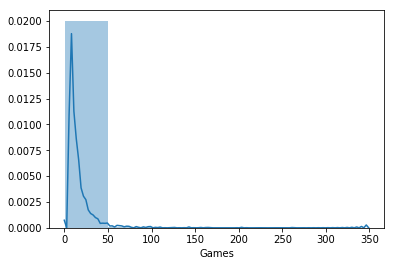

In [225]:
sns.distplot(data_feed['Games'], bins = 7)

## Model architecture

### Output

In [226]:
CAT_DECKS = len(deck_unique)
decks_encoded = to_categorical(data_feed['deck_id_int'], num_classes = CAT_DECKS)
print(decks_encoded)
print(decks_encoded.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(11651, 4512)


In [227]:
data_feed.head()

,Player,Tag,TeamId,DeckId,Archetype,Usage,Games,Wins,Losses,deck_id_int
0,MisterKap,0,0,9244388,0,0,1,1,0,0
1,Arctic Peke,1,1,9244373,1,0,1,0,1,1
2,MisterKap,0,0,9244387,2,0,1,1,0,2
3,PeDrE NO GeMeA!,2,0,9244301,2,1,1,1,0,2
4,#Peppe,3,2,9244236,2,2,11,8,2,2


In [236]:
def get_model(CAT_DECKS):
    player_input = Input(shape=[1], name='player')
    team_input = Input(shape=[1], name='team')
    archetype_input = Input(shape = [1], name = 'archetype')
    usage_input = Input(shape = [1], name = 'usage')
    games_input = Input(shape = [1], name = 'games')
    wins_input = Input(shape = [1], name = 'wins')
    losses_input = Input(shape = [1], name = 'losses')
    deck_input = Input(shape = [1], name = 'deck')

    embedding_size = 10
    deck_embedding_size = 30

    player_embedding = Embedding(output_dim=embedding_size, input_dim = player_unique.shape[0],
                               input_length=1, name='player_embedding')(player_input)
    team_embedding = Embedding(output_dim=embedding_size, input_dim = teams_unique.shape[0],
                               input_length=1, name='team_embedding')(team_input)
    archetype_embedding = Embedding(output_dim=embedding_size, input_dim = archetype_unique.shape[0],
                               input_length=1, name='archetype_embedding')(archetype_input)
    usage_embedding = Embedding(output_dim=embedding_size, input_dim = usage_unique.shape[0],
                               input_length=1, name='usage_embedding')(usage_input)
    deck_embedding = Embedding(output_dim=deck_embedding_size, input_dim = deck_unique.shape[0],
                               input_length=1, name='deck_embedding')(deck_input)


    player_vecs = Reshape([embedding_size])(player_embedding)
    team_vecs = Reshape([embedding_size])(team_embedding)
    arch_vecs = Reshape([embedding_size])(archetype_embedding)
    usage_vecs = Reshape([embedding_size])(usage_embedding)
    deck_vecs = Reshape([deck_embedding_size])(deck_embedding)

    x1 = concatenate([player_vecs, team_vecs, arch_vecs, usage_vecs, deck_vecs,
                     wins_input, losses_input, games_input], name = 'VECTOR_INTERACCION')

    x2 = Dropout(0.4)(x1)
    x3 = Dense (32, activation = 'relu')(x2)
    x4 = Dropout(0.3)(x3)

    output = Dense(CAT_DECKS, activation = 'softmax' )(x4)

    model = Model(inputs=[player_input, team_input, archetype_input, usage_input, games_input, wins_input,
                         losses_input, deck_input] , 
                  outputs = output)

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'rmsprop',
                  metrics = ['acc'])

    model.summary()
    
    return model

In [237]:
data_feed.columns

Index(['Player', 'Tag', 'TeamId', 'DeckId', 'Archetype', 'Usage', 'Games',
       'Wins', 'Losses', 'deck_id_int'],
      dtype='object')

In [238]:
model = get_model(CAT_DECKS)

history = model.fit([data_feed['Tag'], data_feed['TeamId'], data_feed['Archetype'], data_feed['Usage'],
                    data_feed['Games'], data_feed['Wins'], data_feed['Losses'], data_feed['deck_id_int']],
                    decks_encoded,
                    epochs = 3, validation_split = 0.1,
                    batch_size = 32, 
                    shuffle = True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
team (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
archetype (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
usage (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
deck (Inpu